In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use('../../figure_style.mplstyle')

print(torch.cuda.is_available())

True


In [3]:
from matplotlib import collections
import matplotlib as mpl
def plot_mesh(data, mesh, ax,
              cmap=plt.cm.viridis,
              vmin=None, vmax=None,
              colorbar=True,
              colorbar_title=""):

    # Dolfin mesh, stores values on vertices not faces
    coords = mesh.coordinates().T
    cells = mesh.cells().T
    values = data[cells].mean(axis=0)

    xmin, ymin = coords.min(axis=1)
    xmax, ymax = coords.max(axis=1)

    polygons = coords[:, cells]
    polygons = np.moveaxis(polygons, (0, 1, 2), (2, 1, 0))
    col = collections.PolyCollection(polygons)
    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    col.set_color(cmap(norm(values)))
    ax.add_collection(col)
    ax.set(xlim=[xmin, xmax],
           ylim=[ymin, ymax])
    ax.set_aspect(1)

    if colorbar:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        vmin, vmax = sm.get_clim()
        vmean = (vmin + vmax)/2
        cax = ax.inset_axes([1.05, 0, 0.05, 1])
        cbar = plt.colorbar(sm, cax=cax, ax=ax,
                            ticks=[vmin, vmean, vmax])
        cbar.ax.set_ylabel(colorbar_title, rotation=-90)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_with_regression(ax, x, y, color='black', label=''):
    score = r2_score(x, y)
    label = ' '.join([label, f'$R^2$ = {score:.2f}'])
    ax.scatter(x, y, color=color, label=label, s=5)

    model = LinearRegression().fit(x[:,None], y[:,None])
    score = model.score(x[:, None], y[:, None])
    eqn = f'y = {model.coef_[0,0]:.2f} x + {np.squeeze(model.intercept_):.2f}'

    xr = np.array([np.min(x), np.max(x)])[:, None]
    yr = model.predict(xr)
    ax.plot(xr, yr, color=color, label=eqn)


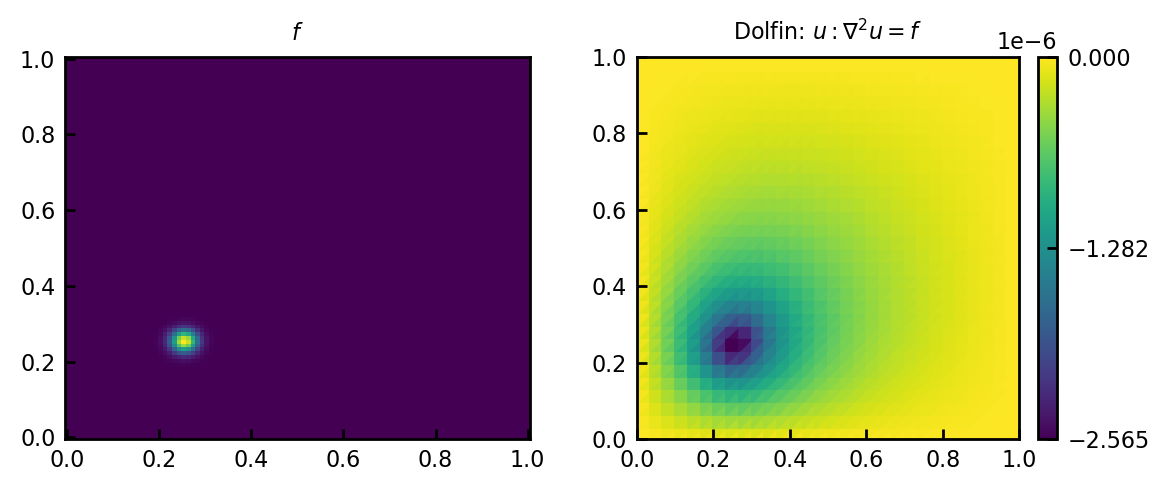

In [36]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros_like(X)
inputs = np.stack([X, Y, C], axis=0)

inputs[2] = 0.
inputs[2, 25, 25] = 1.

from scipy.ndimage import gaussian_filter
def forcing_function(xyc):
    force = gaussian_filter(xyc[2], sigma=2) * np.sin(xyc[0]) * np.sin(xyc[1])
    return force

F = forcing_function(inputs)

mesh = d_ad.UnitSquareMesh(nx=mesh_size, ny=mesh_size)

from scipy.interpolate import NearestNDInterpolator
def solve_forward_problem(X, Y, Force, mesh):
    # Create mesh and function space
    element = ufl.FiniteElement('CG', mesh.ufl_cell(), 1)
    function_space = dlf.FunctionSpace(mesh, element)

    d2v = dlf.dof_to_vertex_map(function_space)
    v2d = dlf.vertex_to_dof_map(function_space)

    # Interpolate the force onto the mesh
    x, y = mesh.coordinates()[:, 0], mesh.coordinates()[:, 1]
    force = NearestNDInterpolator(np.stack([X.flatten(), Y.flatten()], axis=1), Force.flatten())(x, y)
    f = d_ad.Function(function_space)
    f.vector()[:] = force[d2v]

    # Create the boundary condition
    bc = d_ad.DirichletBC(function_space, d_ad.Constant(0.), 'on_boundary')

    # Solve the forward problem using Dolfin
    u = dlf.TrialFunction(function_space)
    v = dlf.TestFunction(function_space)

    a = -ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
    L = f * v * ufl.dx

    u_dolfin = d_ad.Function(function_space)
    d_ad.solve(a == L, u_dolfin, bc)
    dlf_sol = u_dolfin.compute_vertex_values()

    return dlf_sol

dlf_sol = solve_forward_problem(X, Y, F, mesh)

# Plot and compare
fig, ax = plt.subplots(1, 2, figsize=(6,2.5))
ax = ax.flatten()

# Forcing function
ax[0].pcolormesh(X, Y, F)
ax[0].set_title(r'$f$')

# Dolfin solutios
plot_mesh(dlf_sol, mesh, ax[1])
ax[1].set_title(r'Dolfin: $u: \nabla^2 u = f$')

plt.tight_layout()

In [39]:
import h5py
from tqdm import trange

dataset_size = 512
mesh_size = 30
mesh = d_ad.UnitSquareMesh(nx=mesh_size, ny=mesh_size)


X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros_like(X)
inputs = np.stack([X, Y, C], axis=0)

with h5py.File('dataset.hdf5', 'w') as h5f:
    print('Opened file for writing')
    h5f.create_dataset('mesh_size', data=mesh_size)
    h5f.create_dataset('dataset_size', data=dataset_size)

    h5f.create_dataset('inputs', shape=[dataset_size, *inputs.shape], dtype=np.float32)
    h5f.create_dataset('forces', shape=[dataset_size, 1, *inputs.shape[1:]], dtype=np.float32)
    h5f.create_dataset('outputs', shape=[dataset_size, mesh.coordinates().shape[0]])

    for i in trange(dataset_size):
        inputs[2] = 0.
        for j in range(5):
            inputs[2, np.random.randint(25, 75), np.random.randint(25, 75)] += 1.
        force = forcing_function(inputs)

        output = solve_forward_problem(X, Y, force, mesh)

        h5f['inputs'][i] = inputs
        h5f['forces'][i] = force
        h5f['outputs'][i] = output



Opened file for writing


100%|██████████| 512/512 [00:16<00:00, 31.22it/s]


30


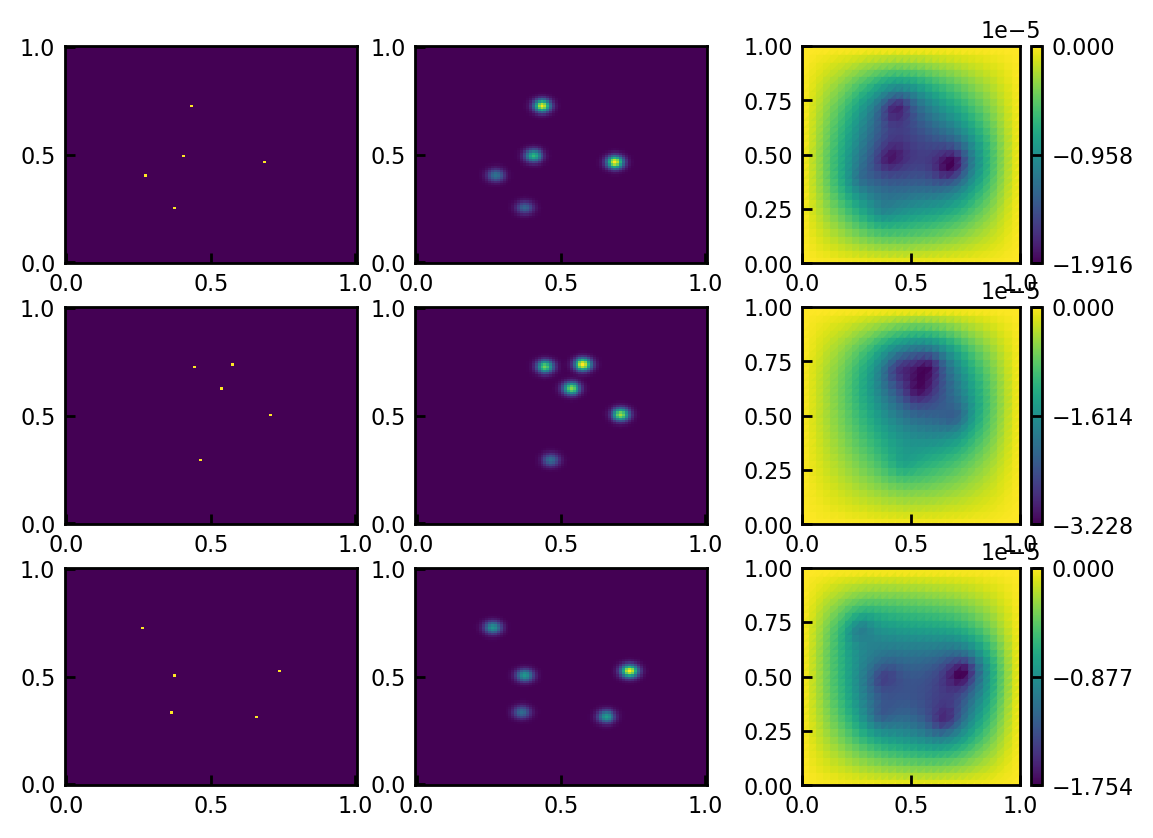

In [40]:
fig, ax = plt.subplots(3, 3)

with h5py.File('dataset.hdf5', 'r') as h5f:
    print(h5f['mesh_size'][()])
    mesh = d_ad.UnitSquareMesh(nx=h5f['mesh_size'][()], ny=h5f['mesh_size'][()])

    for i in range(3):
        inputs = h5f['inputs'][i]
        ax[i, 0].pcolormesh(inputs[0], inputs[1], inputs[2])
        ax[i, 1].pcolormesh(inputs[0], inputs[1], h5f['forces'][i, 0])
        plot_mesh(h5f['outputs'][i], mesh, ax[i, 2])